# Decision Tree on Heart Disease Dataset
During this experiment, various types of Decision Trees will be implemented from scratch using PyTorch.<br>
The models will be trained using the Heart Disease Dataset:
https://archive.ics.uci.edu/ml/datasets/heart+Disease

The 14 features were selected among 76 attributes: 
1. age: age in years
2. sex:
    - 1: male
    - 0: female
3. cp: chest pain type
    - 0: asymptomatic
    - 1: atypical angina
    - 2: non-anginal pain
    - 3: typical angina
4. trestbps: resting blood pressure
5. chol: serum cholestoral in mg/dl
6. fbs: fasting blood sugar > 120 mg/dl
7. restecg: resting electrocardiographic results
    - 0: showing probable or definite left ventricular hypertrophy by Estes' criteria
    - 1: normal
    - 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina 
10. oldpeak: ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
    - 1: upsloping
    - 2: flat
    - 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal:
    - 3 : fixed defect
    - 6 : normal
    - 7 : reversable defect
14. disease:
    - 0: artery diameter narrowing < 50%
    - 1-3: artery diameter narrowing > 50%, close to 3 is very severe

In [98]:
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
hdisease = pd.read_csv(os.path.join('data', 'processed.cleveland.data'))

In [100]:
columns = {
    '63.0' : 'age',
    '1.0' : 'sex',
    '1.0.1' : 'cp',
    '145.0' : 'trestbps',
    '233.0' : 'chol',
    '1.0.2' : 'fbs',
    '2.0' : 'restecg',
    '150.0' : 'thalach',
    '0.0' : 'exang',
    '2.3' : 'oldpeak',
    '3.0' : 'slope',
    '0.0.1' : 'ca',
    '6.0' : 'thal',
    '0' : 'disease'
}
hdisease.rename(columns=columns, inplace=True)

In [101]:
hdisease.loc[hdisease['disease'] > 1, 'disease'] = 1

In [102]:
hdisease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


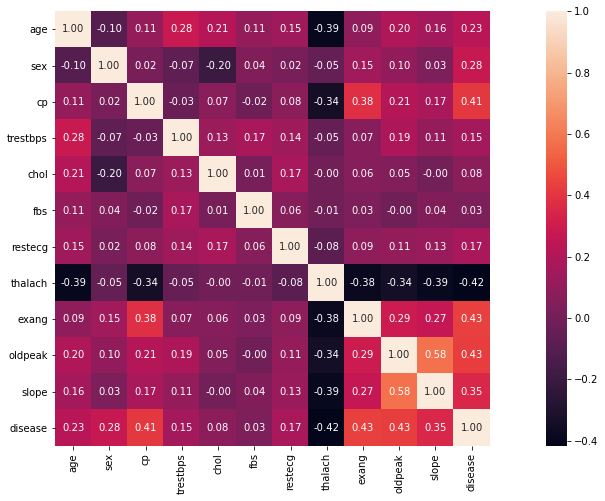

In [103]:
plt.figure(figsize=(20, 8))
sns.heatmap(hdisease.corr(), annot=True, square=True, fmt='0.2f')

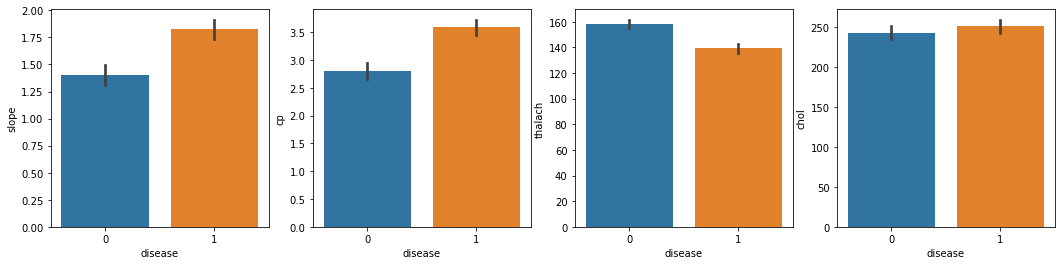

In [109]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4))
sns.barplot(x='disease', y='slope', data=hdisease, ax=ax1)
sns.barplot(x='disease', y='cp', data=hdisease, ax=ax2)
sns.barplot(x='disease', y='thalach', data=hdisease, ax=ax3)
sns.barplot(x='disease', y='chol', data=hdisease, ax=ax4)

Most features are highly correlated to the disease feature, it is likely that patient with heart disease have:
- cp: more chest pain
- thalach: surprisingly, they have lower maximum heart rate. After googling, I found that high beats per minute is signal of heart health
- exang: increase pain when exercising
- oldpeak: the ST segment corresponds to the plateau phase of the ventricular transmembrane action potential, patient have a depression in the potential
- cholesterol levels are similar through sick and healthy patient: you can have heart disease without having cholesterol 

In [90]:
hdisease.loc[hdisease['disease'] == 0, 'thalach'].mean()

158.42944785276075

In [91]:
hdisease.loc[hdisease['disease'] == 1, 'thalach'].mean()

139.25899280575538

The slope of the ST segment of sick patient curves more downward than healthy patients.

### Decision Trees
Descision Trees are defined by recursively partitioning the input space into regions. Each region are then partitioned into sub-regions for each child node.
Each leaf node maps the point to a class or regression value depending on the task. Space is sub-divided into non overlapping regions based on some critera at each node. More formally:
$$
    f(\boldsymbol{x}) = \sum_{m=1}^{M}{w_m}\phi(\boldsymbol{x};\boldsymbol{v}_m)
$$
where$R_m$ is the $m^{th}$ region, $w_m$ is the mean response in this region, and $v_m$ encodes the
choice of variable to split on, and the threshold value, on the path from the root to the $m^{th}$ leaf. We can generalize this to the classification setting by storing the distribution over class labels in each leaf, instead of the mean response.

To understand how to grow a tree, we must introduce de Gini index first.
A